In [2]:
import pandas as pd 
from pandas import DataFrame as df 
import numpy as np 
import scipy.stats as st 
import datetime as dt 
import matplotlib.pyplot as plt 
%matplotlib inline 
import copy 

In [3]:
def logRet(df):
    pri = df
    daily_returns = pri * 0
    for i in range(1, len(pri)-1):
        daily_returns[i] = np.log(pri[i]/pri[i-1])
    return daily_returns

# For a portfolio's returns, gives the index
def indx(ret):
    ret = ret.reset_index(drop=True)
    ind = ret * 0 + 100
    for i in range(1, len(ret)-1):
        ind[i] = ind[i-1] * (1+ret[i])
    return ind

# Cumulative returns

def cumRet(rets):
    cumR = rets * 0 
    for t in range(1, len(cumR)-1):
        cumR[t] = cumR[t-1] + rets[t]
    return cumR

# Risk metric functions

def maxDrawdown(pri, window=252):
    Roll_Max = pri.rolling(window, min_periods=200).max()
    Daily_Drawdown = pri/Roll_Max - 1.0
    Daily_Drawdown *= -1
    Max_Daily_Drawdown = np.max(Daily_Drawdown)
    # print("Max daily drawdown: {}%".format(round(Max_Daily_Drawdown, 2)))
    return Max_Daily_Drawdown

def plotDrawdown(pri, window=252):
    Roll_Max = pri.rolling(window, min_periods=200).max()
    Daily_Drawdown = pri/Roll_Max - 1.0
    Daily_Drawdown *= -1
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    ax.plot(Daily_Drawdown)
    ax.set_xlabel('Year')
    ax.set_ylabel('%')
    ax.set_title('Drawdown')
    plt.show()

def valueAR(dailyRet, per=5): #Historical
    pci = np.percentile(dailyRet, per)
    # print("VaR at {0}%: {1}%".format(per, round(-100*pci, 3)))
    return -pci

def cVaR(dailyRet, per=5):
    pci = np.percentile(dailyRet, per)
    sumBad = 0
    t = 0
    for ret in dailyRet:
        if ret <= pci:
            t += 1
            sumBad += ret
    if t > 0:
        condVaR = sumBad / t
    else:
        condVaR = 0
    # print("CVaR at {0}%: {1}%".format(per, round(-100*condVaR, 3)))
    return -condVaR

def semiv(dayRet, port=False):
    m = np.mean(dayRet)
    low = []
    for ret in dayRet:
        if ret <= m:
            low.append(ret)
    stand = np.std(low)
    if port: 
        stand *= np.sqrt(21)
    # print("SemiSD: {}".format(round(stand, 6)))
    return stand

# Use pricing data
def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak:
            peak = x
        else:
            dd = (peak - x) / peak
            if dd > mdd:
                mdd = dd
    return mdd

# Adjusted to use returns data 
def maxDDRet(rets):
    return max_drawdown(indx(rets))

# SD, SemiV, Drawdown, VaR, CVaR, Skewness, Kurtosis
def riskMetrics(ret, name = "portfolio", varP = 5, cvarP = 5):
    print("Risk metrics for {}".format(name))
    pri = indx(ret)
    print("Average return: {}%".format(round(100*np.mean(ret), 6)))
    sd = np.std(ret)
    print("SD: {}".format(round(sd, 6)))
    semiv(ret)
    dd = max_drawdown(pri)
    print("Max DD: {}%".format(round(100*dd, 2)))
    valueAR(ret, varP)
    cVAR(ret, cvarP)
    sk = st.skew(ret)
    print("Skewness: {}".format(round(sk, 6)))
    kurt = st.kurtosis(ret)
    print("Kurtosis: {}".format(round(kurt+3, 6)))
    print("Excess Kurtosis: {}".format(round(kurt, 6)))
    print("")
    
def cVaRNP(dailyRet, per=5):
    pci = np.percentile(dailyRet, per)
    sumBad = 0
    t = 0
    for ret in dailyRet:
        if ret <= pci:
            t += 1
            sumBad += ret
    if t > 0:
        condVaR = sumBad / t
    else:
        condVaR = 0
    # print("CVaR at {0}%: {1}%".format(per, np.round(float(-100*condVaR), 3)))
    return -condVaR

def riskMetricsNP(ret, name = "portfolio", varP = 5, cvarP = 5, port=False):
    print("Risk metrics for {}".format(name))
    pri = indx(ret)
    print("Average return: {}%".format(round(100*np.mean(ret), 6)))
    sd = np.std(ret)
    # Note change for monthly to work for portfolio 
    if port: 
        print("SD: {}".format(np.round(sd*np.sqrt(21), 6)))
    else: 
        print("SD: {}".format(np.round(sd, 6)))
    semiv(ret, port=True)
    dd = max_drawdown(pri)
    print("Max DD: {}%".format(np.round(float(100*dd), 2)))
    valueAR(ret, varP)
    cVaRNP(ret, cvarP)
    sk = st.skew(ret)
    print("Skewness: {}".format(np.round(float(sk), 6)))
    kurt = st.kurtosis(ret)
    print("Kurtosis: {}".format(round(kurt+3, 6)))
    print("Excess Kurtosis: {}".format(np.round(float(kurt), 6)))
    print("")

In [3]:
data2000 = pd.read_csv('US2000.csv')

In [4]:
data2000['date'] = pd.to_datetime(data2000['date'], format='%d/%m/%Y')
data2000['PRC'][data2000['PRC'] < 0] *= -1
data2000['AdjP'] = data2000['PRC'] / data2000['CFACPR']
data2000['Ret'] = np.log(data2000['AdjP'] / data2000['AdjP'].shift())
data2000 = data2000.groupby('PERMNO').apply(lambda x: x.iloc[1:]).reset_index(drop=True)
data2000['year'] = data2000['date'].dt.year
data2000.head()

/Users/Chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Chris/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PERMNO,date,PERMCO,PRC,VOL,CFACPR,sprtrn,AdjP,Ret,year
0,10001,2000-01-04,7953,8.4375,1080.0,1.5,-0.038345,5.625000,-0.014706,2000
1,10001,2000-01-05,7953,8.5625,1711.0,1.5,0.001922,5.708333,0.014706,2000
2,10001,2000-01-06,7953,8.5000,580.0,1.5,0.000956,5.666667,-0.007326,2000
3,10001,2000-01-07,7953,8.4375,1406.0,1.5,0.027090,5.625000,-0.007380,2000
4,10001,2000-01-10,7953,8.4375,3390.0,1.5,0.011190,5.625000,0.000000,2000


In [5]:
try: 
    smry = pd.read_csv('smry.csv')
    smry['year'] = pd.to_datetime(smry['year'])
except: 
    smry = data2000.groupby(['PERMNO', 'year'], as_index=False).agg({'date': 'max', 'Ret': ['size', 'mean', 'var', st.skew, st.kurtosis, valueAR, cVaR, maxDDRet, semiv]}).dropna()
    smry.columns = ['PERMNO', 'year', 'max', 'size', 'mean', 'variance', 'skew', 'kurtosis', 'VaR', 'CVaR', 'MaxDD', 'Semiv']
    smry['kurtosis'] += 3
    smry = smry[smry['size'] > 200]
    smry[['nmean', 'nvariance', 'nskew', 'nkurtosis']] = smry[['mean', 'variance', 'skew', 'kurtosis']].shift(-1)

In [6]:
smry[['nmean', 'nvariance', 'nskew', 'nkurtosis']] = smry[['mean', 'variance', 'skew', 'kurtosis']].shift(-1)
smry.head()

,PERMNO,year,mean,variance,skew,kurtosis,VaR,CVaR,MaxDD,Semiv,...,nskew,nkurtosis,mean2,variance2,skew2,kurtosis2,mean3,variance3,skew3,kurtosis3
0,10001,2000-01-01,0.000517,0.000516,-0.013382,3.730050,0.038458,0.049853,0.152208,0.015620,...,-0.358962,11.800299,2.677344e-07,2.658095e-07,0.000179,13.913269,1.385340e-10,1.370426e-10,-0.000002,51.897183
1,10001,2001-01-01,0.000648,0.000908,-0.358962,11.800299,0.042742,0.067054,0.305908,0.022719,...,-0.258249,4.406784,4.200004e-07,8.246121e-07,0.128854,139.247057,2.721915e-10,7.488150e-10,-0.046254,1643.156918
2,10001,2002-01-01,-0.001759,0.000335,-0.258249,4.406784,0.033637,0.043516,0.384337,0.013564,...,-0.040212,9.426603,3.092481e-06,1.121894e-07,0.066693,19.419741,-5.438267e-09,3.757747e-11,-0.017223,85.578596
3,10001,2003-01-01,-0.000839,0.001030,-0.040212,9.426603,0.044208,0.080958,0.452394,0.025295,...,0.638468,7.658105,7.040351e-07,1.060161e-06,0.001617,88.860835,-5.907334e-10,1.091586e-09,-0.000065,837.655778
4,10001,2004-01-01,0.000588,0.000714,0.638468,7.658105,0.041834,0.058435,0.335233,0.018147,...,1.392394,7.646879,3.455303e-07,5.100324e-07,0.407642,58.646577,2.031090e-10,3.642475e-10,0.260266,449.121667


In [7]:
try: 
    smry = smry.groupby('PERMNO').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
    smry['year'] = pd.to_datetime(smry['year'], format='%Y')
    smry = smry.drop(['max', 'size'], axis=1)
    smry = smry.dropna()
except: 
    pass
smry.head()

,PERMNO,year,mean,variance,skew,kurtosis,VaR,CVaR,MaxDD,Semiv,...,nskew,nkurtosis,mean2,variance2,skew2,kurtosis2,mean3,variance3,skew3,kurtosis3
0,10001,2000-01-01,0.000517,0.000516,-0.013382,3.730050,0.038458,0.049853,0.152208,0.015620,...,-0.358962,11.800299,2.677344e-07,2.658095e-07,0.000179,13.913269,1.385340e-10,1.370426e-10,-0.000002,51.897183
1,10001,2001-01-01,0.000648,0.000908,-0.358962,11.800299,0.042742,0.067054,0.305908,0.022719,...,-0.258249,4.406784,4.200004e-07,8.246121e-07,0.128854,139.247057,2.721915e-10,7.488150e-10,-0.046254,1643.156918
2,10001,2002-01-01,-0.001759,0.000335,-0.258249,4.406784,0.033637,0.043516,0.384337,0.013564,...,-0.040212,9.426603,3.092481e-06,1.121894e-07,0.066693,19.419741,-5.438267e-09,3.757747e-11,-0.017223,85.578596
3,10001,2003-01-01,-0.000839,0.001030,-0.040212,9.426603,0.044208,0.080958,0.452394,0.025295,...,0.638468,7.658105,7.040351e-07,1.060161e-06,0.001617,88.860835,-5.907334e-10,1.091586e-09,-0.000065,837.655778
4,10001,2004-01-01,0.000588,0.000714,0.638468,7.658105,0.041834,0.058435,0.335233,0.018147,...,1.392394,7.646879,3.455303e-07,5.100324e-07,0.407642,58.646577,2.031090e-10,3.642475e-10,0.260266,449.121667


In [8]:
# Add any more multiples or powers of parameters deemed necessary now 
for i in range(2,5):
    smry['mean'+str(i)] = smry['mean'] ** i
    smry['variance'+str(i)] = smry['variance'] ** i
    smry['skew'+str(i)] = smry['skew'] ** i
    smry['kurtosis'+str(i)] = smry['kurtosis'] ** i
    
smrycopy = copy.deepcopy(smry)
# smry.to_csv('smry.csv', index=False)

In [9]:
smry.columns

Index(['PERMNO', 'year', 'mean', 'variance', 'skew', 'kurtosis', 'VaR', 'CVaR',
       'MaxDD', 'Semiv', 'nmean', 'nvariance', 'nskew', 'nkurtosis', 'mean2',
       'variance2', 'skew2', 'kurtosis2', 'mean3', 'variance3', 'skew3',
       'kurtosis3', 'mean4', 'variance4', 'skew4', 'kurtosis4'],
      dtype='object')

In [10]:
smry.describe()
smry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79315 entries, 0 to 79314
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PERMNO     79315 non-null  int64         
 1   year       79315 non-null  datetime64[ns]
 2   mean       79315 non-null  float64       
 3   variance   79315 non-null  float64       
 4   skew       79315 non-null  float64       
 5   kurtosis   79315 non-null  float64       
 6   VaR        79315 non-null  float64       
 7   CVaR       79315 non-null  float64       
 8   MaxDD      79315 non-null  float64       
 9   Semiv      79315 non-null  float64       
 10  nmean      79315 non-null  float64       
 11  nvariance  79315 non-null  float64       
 12  nskew      79315 non-null  float64       
 13  nkurtosis  79315 non-null  float64       
 14  mean2      79315 non-null  float64       
 15  variance2  79315 non-null  float64       
 16  skew2      79315 non-null  float64      

In [11]:
# alterations to smry to test adjustments 
sqsmry = copy.deepcopy(smry)
sqsmry.iloc[:, 2:] = sqsmry[:].iloc[:,2:] ** 2
logsqsmry = copy.copy(sqsmry)
logsqsmry.iloc[:, 2:] = np.log(logsqsmry[:].iloc[:, 2:] + 1)
absmry = copy.deepcopy(smry) 
absmry.iloc[:, 2:] = abs(absmry.iloc[:, 2:])
logabsmry = copy.copy(absmry) 
logabsmry.iloc[:, 2:] = np.log(absmry.iloc[:, 2:] + 1)
plusmry = copy.deepcopy(smry)
plusmry.iloc[:, 2:] = plusmry.iloc[:, 2:] - np.min(plusmry.iloc[:, 2:])
logplusmry = copy.copy(plusmry) 
logplusmry.iloc[:, 2:] = np.log(plusmry.iloc[:, 2:] + 1)

In [12]:
print(sum((smrycopy - smry).values != 0))
smrycopy

[    0 79315     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


,PERMNO,year,mean,variance,skew,kurtosis,VaR,CVaR,MaxDD,Semiv,...,skew2,kurtosis2,mean3,variance3,skew3,kurtosis3,mean4,variance4,skew4,kurtosis4
0,10001,2000-01-01,0.000517,0.000516,-0.013382,3.730050,0.038458,0.049853,0.152208,0.015620,...,0.000179,13.913269,1.385340e-10,1.370426e-10,-0.000002,51.897183,7.168172e-14,7.065466e-14,3.207162e-08,193.579063
1,10001,2001-01-01,0.000648,0.000908,-0.358962,11.800299,0.042742,0.067054,0.305908,0.022719,...,0.128854,139.247057,2.721915e-10,7.488150e-10,-0.046254,1643.156918,1.764003e-13,6.799851e-13,1.660329e-02,19389.743001
2,10001,2002-01-01,-0.001759,0.000335,-0.258249,4.406784,0.033637,0.043516,0.384337,0.013564,...,0.066693,19.419741,-5.438267e-09,3.757747e-11,-0.017223,85.578596,9.563438e-12,1.258646e-14,4.447905e-03,377.126349
3,10001,2003-01-01,-0.000839,0.001030,-0.040212,9.426603,0.044208,0.080958,0.452394,0.025295,...,0.001617,88.860835,-5.907334e-10,1.091586e-09,-0.000065,837.655778,4.956655e-13,1.123942e-12,2.614628e-06,7896.248085
4,10001,2004-01-01,0.000588,0.000714,0.638468,7.658105,0.041834,0.058435,0.335233,0.018147,...,0.407642,58.646577,2.031090e-10,3.642475e-10,0.260266,449.121667,1.193912e-13,2.601330e-13,1.661719e-01,3439.421038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79310,93436,2011-01-01,0.000278,0.001013,0.529470,5.987900,0.049580,0.065687,0.294424,0.019815,...,0.280338,35.854952,2.140477e-11,1.040549e-09,0.148431,214.695885,5.943113e-15,1.054428e-12,7.858950e-02,1285.577590
79311,93436,2012-01-01,0.000682,0.001143,-0.682840,10.754609,0.046433,0.077833,0.348228,0.025978,...,0.466270,115.661607,3.173403e-10,1.492081e-09,-0.318388,1243.895313,2.164547e-13,1.704996e-12,2.174079e-01,13377.607268
79312,93436,2013-01-01,0.005917,0.001751,0.566829,7.976268,0.055171,0.084741,0.786385,0.028234,...,0.321295,63.620850,2.071084e-07,5.368356e-09,0.182119,507.456949,1.225360e-09,9.399867e-12,1.032302e-01,4047.612600
79313,93436,2014-01-01,0.001552,0.000907,0.486219,7.087730,0.043235,0.062884,0.430912,0.019443,...,0.236409,50.235916,3.736225e-09,7.464386e-10,0.114947,356.058611,5.797543e-12,6.771093e-13,5.588928e-02,2523.647290


In [34]:
smry = pd.read_csv('smry.csv').dropna()

In [23]:
import tensorflow as tf 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix
import random
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
X = smry.drop(['PERMNO', 'year', 'nmean', 'nvariance', 'nskew', 'nkurtosis'],axis=1).values
y = smry[['nmean', 'nvariance', 'nskew', 'nkurtosis']].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
# X_train = scaler.fit_transform(np.log(scaler.fit_transform(X_train) + 1))
X_test = scaler.transform(X_test)
# X_test = scaler.fit_transform(np.log(scaler.fit_transform(X_test) + 1))

In [39]:
# 2 hidden layers 
model = Sequential()

model.add(Dense(20,activation='relu'))

for i in range(3):
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.25))

model.add(Dense(4))

model.compile(optimizer='adam',loss='mse')

In [40]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [41]:
model.fit(x=X_train, 
         y=y_train, 
         epochs=150, 
          batch_size=256, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stop]
         )

Epoch 1/150
283/283 [==============================] - 0s 1ms/step - loss: 45.7054 - val_loss: 37.6752
Epoch 2/150
283/283 [==============================] - 0s 1ms/step - loss: 41.4345 - val_loss: 37.7765
Epoch 3/150
283/283 [==============================] - 0s 1ms/step - loss: 41.0848 - val_loss: 37.7127
Epoch 4/150
283/283 [==============================] - 0s 1ms/step - loss: 40.9260 - val_loss: 37.5374
Epoch 5/150
283/283 [==============================] - 0s 1ms/step - loss: 40.7164 - val_loss: 37.4979
Epoch 6/150
283/283 [==============================] - 0s 1ms/step - loss: 40.6331 - val_loss: 37.3036
Epoch 7/150
283/283 [==============================] - 0s 1ms/step - loss: 40.4631 - val_loss: 37.3661
Epoch 8/150
283/283 [==============================] - 0s 1ms/step - loss: 40.4046 - val_loss: 37.2064
Epoch 9/150
283/283 [==============================] - 0s 1ms/step - loss: 40.3888 - val_loss: 37.2096
Epoch 10/150
283/283 [==============================] - 0s 1ms/step - los

Epoch 80/150
283/283 [==============================] - 0s 1ms/step - loss: 39.6467 - val_loss: 36.9382
Epoch 81/150
283/283 [==============================] - 0s 1ms/step - loss: 39.6036 - val_loss: 36.9375
Epoch 82/150
283/283 [==============================] - 0s 1ms/step - loss: 39.6762 - val_loss: 36.8879
Epoch 00082: early stopping


In [59]:
losses = pd.DataFrame(model.history.history)
losses.plot()

TypeError: no numeric data to plot

In [60]:
pred = model.predict(X_test)
pred

array([[ 7.5014937e-04,  1.0616789e-03, -1.3411489e-01,  8.3517666e+00],
       [ 8.9446385e-04,  1.3147183e-03, -1.1500132e-01,  9.4057875e+00],
       [ 8.1997208e-04,  1.1788096e-03, -1.2490746e-01,  8.8547659e+00],
       ...,
       [ 9.0669160e-04,  1.3429506e-03, -1.1328645e-01,  9.5048189e+00],
       [ 7.9773826e-04,  1.1394683e-03, -1.2784767e-01,  8.6921597e+00],
       [ 8.5341174e-04,  1.2384235e-03, -1.2048438e-01,  9.1000223e+00]],
      dtype=float32)

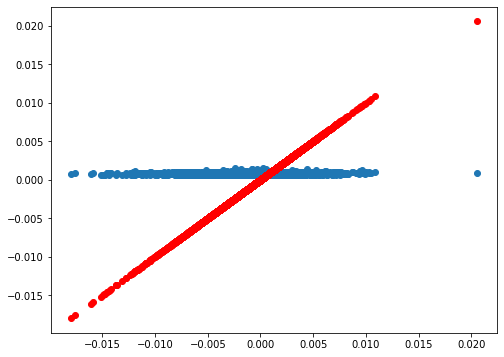

In [61]:
plt.figure(figsize=(8,6))
plt.scatter(y_test[:,0], pred[:,0])
plt.scatter(y_test[:,0], y_test[:,0], color='r')

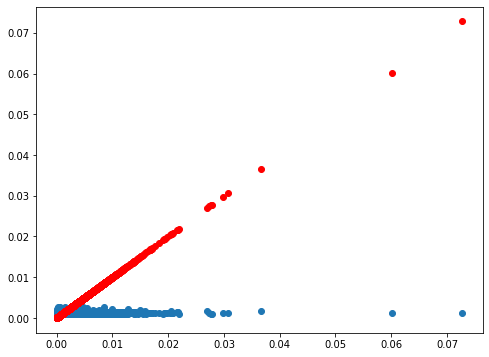

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(y_test[:,1], pred[:,1])
plt.scatter(y_test[:,1], y_test[:,1], color='r')

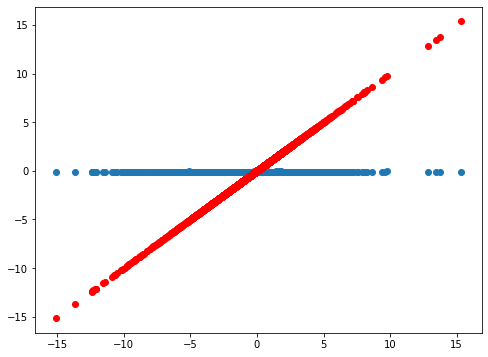

In [63]:
plt.figure(figsize=(8,6))
plt.scatter(y_test[:,2], pred[:,2])
plt.scatter(y_test[:,2], y_test[:,2], color='r')

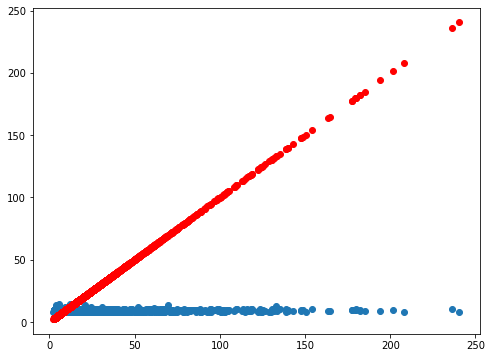

In [64]:
plt.figure(figsize=(8,6))
plt.scatter(y_test[:,3], pred[:,3])
plt.scatter(y_test[:,3], y_test[:,3], color='r')

In [48]:
np.shape(X)[1]

16

In [49]:
def optModel(a=8,b=8):
    bestLoss = 1e12
    bestA = -1
    bestB = -1
    for i in range(a):
        for j in range(b):
            model = Sequential()

            model.add(Dense(np.shape(X)[1],activation='relu'))

            for i in range(2+i):
                model.add(Dense(np.shape(X)[1],activation='relu'))
                model.add(Dropout(1/(2+j)))

            model.add(Dense(4))

            model.compile(optimizer='adam',loss='mse')

            early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

        model.fit(x=X_train, 
                  y=y_train, 
                  epochs=150, 
                    batch_size=256, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop]
                  )
        l = pd.DataFrame(model.history.history).iloc[0,-1]
        if l < bestLoss:
            bestLoss = l
            bestA = i
            bestB = j
    
    return bestLoss, bestA, bestB

In [80]:
bst = optModel()

Epoch 1/150
248/248 [==============================] - 0s 1ms/step - loss: 48.9470 - val_loss: 40.9405
Epoch 2/150
248/248 [==============================] - 0s 1ms/step - loss: 42.5024 - val_loss: 40.8058
Epoch 3/150
248/248 [==============================] - 0s 1ms/step - loss: 41.3176 - val_loss: 40.3759
Epoch 4/150
248/248 [==============================] - 0s 1ms/step - loss: 40.9090 - val_loss: 39.9191
Epoch 5/150
248/248 [==============================] - 0s 1ms/step - loss: 40.4645 - val_loss: 39.6769
Epoch 6/150
248/248 [==============================] - 0s 1ms/step - loss: 40.3352 - val_loss: 39.5973
Epoch 7/150
248/248 [==============================] - 0s 1ms/step - loss: 40.1221 - val_loss: 39.4363
Epoch 8/150
248/248 [==============================] - 0s 1ms/step - loss: 40.1325 - val_loss: 39.4883
Epoch 9/150
248/248 [==============================] - 0s 1ms/step - loss: 39.9725 - val_loss: 39.3100
Epoch 10/150
248/248 [==============================] - 0s 1ms/step - los

248/248 [==============================] - 0s 1ms/step - loss: 38.5835 - val_loss: 38.6721
Epoch 20/150
248/248 [==============================] - 0s 1ms/step - loss: 38.6434 - val_loss: 38.3121
Epoch 21/150
248/248 [==============================] - 0s 1ms/step - loss: 38.7137 - val_loss: 38.5225
Epoch 22/150
248/248 [==============================] - 0s 1ms/step - loss: 38.6113 - val_loss: 38.7124
Epoch 23/150
248/248 [==============================] - 0s 1ms/step - loss: 38.5519 - val_loss: 38.3716
Epoch 24/150
248/248 [==============================] - 0s 1ms/step - loss: 38.6069 - val_loss: 38.6123
Epoch 25/150
248/248 [==============================] - 0s 2ms/step - loss: 38.5856 - val_loss: 38.4822
Epoch 26/150
248/248 [==============================] - 0s 2ms/step - loss: 38.6079 - val_loss: 38.5820
Epoch 27/150
248/248 [==============================] - 0s 1ms/step - loss: 38.4470 - val_loss: 38.4866
Epoch 28/150
248/248 [==============================] - 0s 2ms/step - loss: 3

248/248 [==============================] - 0s 1ms/step - loss: 39.7004 - val_loss: 39.2501
Epoch 7/150
248/248 [==============================] - 0s 1ms/step - loss: 39.6043 - val_loss: 38.9345
Epoch 8/150
248/248 [==============================] - 0s 1ms/step - loss: 39.5326 - val_loss: 39.0531
Epoch 9/150
248/248 [==============================] - 0s 1ms/step - loss: 39.3635 - val_loss: 38.8775
Epoch 10/150
248/248 [==============================] - 0s 1ms/step - loss: 39.4704 - val_loss: 38.9683
Epoch 11/150
248/248 [==============================] - 0s 1ms/step - loss: 39.1902 - val_loss: 38.9074
Epoch 12/150
248/248 [==============================] - 0s 1ms/step - loss: 39.1806 - val_loss: 38.9393
Epoch 13/150
248/248 [==============================] - 0s 1ms/step - loss: 39.2750 - val_loss: 38.8300
Epoch 14/150
248/248 [==============================] - 0s 1ms/step - loss: 39.1364 - val_loss: 38.6510
Epoch 15/150
248/248 [==============================] - 0s 1ms/step - loss: 39.0

248/248 [==============================] - 0s 2ms/step - loss: 38.6715 - val_loss: 38.5613
Epoch 17/150
248/248 [==============================] - 0s 2ms/step - loss: 38.6194 - val_loss: 39.0000
Epoch 18/150
248/248 [==============================] - 0s 2ms/step - loss: 38.5616 - val_loss: 38.9141
Epoch 19/150
248/248 [==============================] - 0s 2ms/step - loss: 38.5735 - val_loss: 38.8255
Epoch 20/150
248/248 [==============================] - 0s 2ms/step - loss: 38.5382 - val_loss: 38.6564
Epoch 21/150
248/248 [==============================] - 0s 2ms/step - loss: 38.5281 - val_loss: 38.5297
Epoch 22/150
248/248 [==============================] - 0s 2ms/step - loss: 38.5386 - val_loss: 38.6564
Epoch 23/150
248/248 [==============================] - 0s 2ms/step - loss: 38.5775 - val_loss: 38.6687
Epoch 24/150
248/248 [==============================] - 0s 2ms/step - loss: 38.5173 - val_loss: 38.3183
Epoch 25/150
248/248 [==============================] - 0s 2ms/step - loss: 3

248/248 [==============================] - 0s 1ms/step - loss: 38.5928 - val_loss: 38.4927
Epoch 27/150
248/248 [==============================] - 0s 1ms/step - loss: 38.5632 - val_loss: 38.5820
Epoch 28/150
248/248 [==============================] - 0s 1ms/step - loss: 38.6233 - val_loss: 38.4013
Epoch 29/150
248/248 [==============================] - 0s 1ms/step - loss: 38.5959 - val_loss: 38.7830
Epoch 30/150
248/248 [==============================] - 0s 1ms/step - loss: 38.5725 - val_loss: 38.8217
Epoch 31/150
248/248 [==============================] - 0s 1ms/step - loss: 38.5692 - val_loss: 38.5573
Epoch 32/150
248/248 [==============================] - 0s 1ms/step - loss: 38.5457 - val_loss: 38.4838
Epoch 33/150
248/248 [==============================] - 0s 1ms/step - loss: 38.5202 - val_loss: 39.0469
Epoch 34/150
248/248 [==============================] - 0s 1ms/step - loss: 38.5926 - val_loss: 38.4041
Epoch 35/150
248/248 [==============================] - 0s 1ms/step - loss: 3

248/248 [==============================] - 0s 1ms/step - loss: 39.5280 - val_loss: 39.4144
Epoch 22/150
248/248 [==============================] - 0s 1ms/step - loss: 39.4104 - val_loss: 39.4411
Epoch 23/150
248/248 [==============================] - 0s 1ms/step - loss: 39.3859 - val_loss: 39.5196
Epoch 00023: early stopping
Epoch 1/150
248/248 [==============================] - 0s 2ms/step - loss: 46.4226 - val_loss: 40.7904
Epoch 2/150
248/248 [==============================] - 0s 1ms/step - loss: 40.8388 - val_loss: 39.9802
Epoch 3/150
248/248 [==============================] - 0s 1ms/step - loss: 40.3337 - val_loss: 39.4579
Epoch 4/150
248/248 [==============================] - 0s 1ms/step - loss: 39.9664 - val_loss: 39.1365
Epoch 5/150
248/248 [==============================] - 0s 1ms/step - loss: 39.8859 - val_loss: 39.5039
Epoch 6/150
248/248 [==============================] - 0s 1ms/step - loss: 39.7407 - val_loss: 39.1767
Epoch 7/150
248/248 [==============================] - 

248/248 [==============================] - 0s 2ms/step - loss: 39.1379 - val_loss: 39.1069
Epoch 5/150
248/248 [==============================] - 0s 2ms/step - loss: 38.9894 - val_loss: 38.7997
Epoch 6/150
248/248 [==============================] - 0s 2ms/step - loss: 38.9533 - val_loss: 38.9272
Epoch 7/150
248/248 [==============================] - 0s 2ms/step - loss: 38.9019 - val_loss: 38.6328
Epoch 8/150
248/248 [==============================] - 0s 2ms/step - loss: 38.8382 - val_loss: 38.7873
Epoch 9/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7834 - val_loss: 38.6052
Epoch 10/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7961 - val_loss: 39.2287
Epoch 11/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7009 - val_loss: 39.0597
Epoch 12/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7552 - val_loss: 39.1624
Epoch 13/150
248/248 [==============================] - 0s 2ms/step - loss: 38.646

248/248 [==============================] - 0s 2ms/step - loss: 38.8733 - val_loss: 38.6955
Epoch 14/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7676 - val_loss: 39.2172
Epoch 15/150
248/248 [==============================] - 0s 2ms/step - loss: 38.8433 - val_loss: 39.0976
Epoch 16/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7948 - val_loss: 39.0446
Epoch 17/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7711 - val_loss: 39.1594
Epoch 18/150
248/248 [==============================] - 0s 2ms/step - loss: 38.6740 - val_loss: 38.8728
Epoch 19/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7279 - val_loss: 39.5769
Epoch 20/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7139 - val_loss: 38.8086
Epoch 21/150
248/248 [==============================] - 0s 2ms/step - loss: 38.6778 - val_loss: 39.2473
Epoch 22/150
248/248 [==============================] - 0s 2ms/step - loss: 3

248/248 [==============================] - 0s 2ms/step - loss: 38.7886 - val_loss: 39.2558
Epoch 27/150
248/248 [==============================] - 0s 2ms/step - loss: 38.8140 - val_loss: 39.0782
Epoch 28/150
248/248 [==============================] - 0s 2ms/step - loss: 38.8159 - val_loss: 39.1306
Epoch 29/150
248/248 [==============================] - 0s 2ms/step - loss: 38.8022 - val_loss: 38.7153
Epoch 30/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7732 - val_loss: 39.0410
Epoch 31/150
248/248 [==============================] - 0s 2ms/step - loss: 38.6940 - val_loss: 39.0750
Epoch 32/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7897 - val_loss: 39.0178
Epoch 33/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7256 - val_loss: 39.1646
Epoch 34/150
248/248 [==============================] - 0s 2ms/step - loss: 38.6109 - val_loss: 39.2687
Epoch 35/150
248/248 [==============================] - 0s 2ms/step - loss: 3

248/248 [==============================] - 0s 2ms/step - loss: 40.0175 - val_loss: 39.8571
Epoch 15/150
248/248 [==============================] - 0s 2ms/step - loss: 39.8668 - val_loss: 39.6629
Epoch 16/150
248/248 [==============================] - 0s 1ms/step - loss: 39.8341 - val_loss: 39.8131
Epoch 17/150
248/248 [==============================] - 0s 1ms/step - loss: 39.8129 - val_loss: 39.6531
Epoch 18/150
248/248 [==============================] - 0s 2ms/step - loss: 39.7980 - val_loss: 39.8247
Epoch 19/150
248/248 [==============================] - 0s 2ms/step - loss: 39.6101 - val_loss: 39.7807
Epoch 20/150
248/248 [==============================] - 0s 2ms/step - loss: 39.6971 - val_loss: 39.7690
Epoch 21/150
248/248 [==============================] - 0s 2ms/step - loss: 39.6033 - val_loss: 39.7453
Epoch 22/150
248/248 [==============================] - 0s 2ms/step - loss: 39.4978 - val_loss: 39.6773
Epoch 23/150
248/248 [==============================] - 0s 2ms/step - loss: 3

248/248 [==============================] - 0s 2ms/step - loss: 39.0040 - val_loss: 39.3757
Epoch 8/150
248/248 [==============================] - 1s 2ms/step - loss: 39.0906 - val_loss: 39.5115
Epoch 9/150
248/248 [==============================] - 1s 2ms/step - loss: 38.9621 - val_loss: 39.0267
Epoch 10/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7775 - val_loss: 39.2450
Epoch 11/150
248/248 [==============================] - 0s 2ms/step - loss: 38.8690 - val_loss: 39.1712
Epoch 12/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7742 - val_loss: 38.9242
Epoch 13/150
248/248 [==============================] - 0s 2ms/step - loss: 38.7612 - val_loss: 38.6857
Epoch 14/150
248/248 [==============================] - 1s 2ms/step - loss: 38.8047 - val_loss: 39.0468
Epoch 15/150
248/248 [==============================] - 1s 2ms/step - loss: 38.7582 - val_loss: 39.2387
Epoch 16/150
248/248 [==============================] - 1s 2ms/step - loss: 38.

248/248 [==============================] - 0s 2ms/step - loss: 38.8581 - val_loss: 39.3196
Epoch 32/150
248/248 [==============================] - 0s 2ms/step - loss: 38.9457 - val_loss: 39.1200
Epoch 00032: early stopping
Epoch 1/150
248/248 [==============================] - 1s 2ms/step - loss: 46.3854 - val_loss: 40.5313
Epoch 2/150
248/248 [==============================] - 1s 2ms/step - loss: 40.7214 - val_loss: 39.7684
Epoch 3/150
248/248 [==============================] - 1s 2ms/step - loss: 39.8694 - val_loss: 39.8977
Epoch 4/150
248/248 [==============================] - 0s 2ms/step - loss: 39.5792 - val_loss: 39.4587
Epoch 5/150
248/248 [==============================] - 0s 2ms/step - loss: 39.4625 - val_loss: 39.0271
Epoch 6/150
248/248 [==============================] - 0s 2ms/step - loss: 39.2266 - val_loss: 39.2579
Epoch 7/150
248/248 [==============================] - 0s 2ms/step - loss: 39.2803 - val_loss: 39.3107
Epoch 8/150
248/248 [==============================] - 0

Epoch 5/150
248/248 [==============================] - 2s 6ms/step - loss: 39.0587 - val_loss: 39.6818
Epoch 6/150
248/248 [==============================] - 1s 6ms/step - loss: 39.1229 - val_loss: 39.6580
Epoch 7/150
248/248 [==============================] - 1s 6ms/step - loss: 38.9484 - val_loss: 39.6214
Epoch 8/150
248/248 [==============================] - 1s 6ms/step - loss: 38.9272 - val_loss: 38.7849
Epoch 9/150
248/248 [==============================] - 1s 6ms/step - loss: 38.9412 - val_loss: 39.1907
Epoch 10/150
248/248 [==============================] - 1s 6ms/step - loss: 38.8890 - val_loss: 39.4778
Epoch 11/150
248/248 [==============================] - 1s 6ms/step - loss: 38.8211 - val_loss: 39.3104
Epoch 12/150
248/248 [==============================] - 1s 6ms/step - loss: 38.7346 - val_loss: 38.9018
Epoch 13/150
248/248 [==============================] - 1s 6ms/step - loss: 38.7414 - val_loss: 39.1973
Epoch 14/150
248/248 [==============================] - 1s 5ms/step -

In [81]:
bst

(39.63009262084961, 10, 4)

In [50]:
a = 10; b = 4
bestLoss = 1e12
bestA = -1
bestB = -1
model = Sequential()

model.add(Dense(np.shape(X)[1],activation='relu'))

for i in range(2+a):
    model.add(Dense(np.shape(X)[1],activation='relu'))
    model.add(Dropout(1/(2+b)))

model.add(Dense(4))

model.compile(optimizer='adam',loss='mse')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

model.fit(x=X_train, 
      y=y_train, 
      epochs=150, 
        batch_size=256, 
        validation_data=(X_test, y_test), 
        callbacks=[early_stop]
      )
l = pd.DataFrame(model.history.history).iloc[0,-1]
if l < bestLoss:
    bestLoss = l
    bestA = i
    bestB = j

Epoch 1/150
283/283 [==============================] - 1s 2ms/step - loss: 46.9547 - val_loss: 38.8302
Epoch 2/150
283/283 [==============================] - 0s 2ms/step - loss: 41.6621 - val_loss: 37.9488
Epoch 3/150
283/283 [==============================] - 0s 2ms/step - loss: 41.1320 - val_loss: 37.7648
Epoch 4/150
283/283 [==============================] - 0s 2ms/step - loss: 40.8469 - val_loss: 37.6603
Epoch 5/150
283/283 [==============================] - 0s 2ms/step - loss: 40.6922 - val_loss: 37.6953
Epoch 6/150
283/283 [==============================] - 0s 2ms/step - loss: 40.6451 - val_loss: 37.6303
Epoch 7/150
283/283 [==============================] - 0s 2ms/step - loss: 40.6070 - val_loss: 37.8697
Epoch 8/150
283/283 [==============================] - 0s 2ms/step - loss: 40.4877 - val_loss: 37.6219
Epoch 9/150
283/283 [==============================] - 0s 2ms/step - loss: 40.4547 - val_loss: 37.5327
Epoch 10/150
283/283 [==============================] - 0s 2ms/step - los

In [58]:
pred = model.predict(X_test)
sklearn.metrics.r2_score(y_test[:,0], pred[:,0]), sklearn.metrics.r2_score(y_test[:,1], pred[:,1]), sklearn.metrics.r2_score(y_test[:,2], pred[:,2]), sklearn.metrics.r2_score(y_test[:,3], pred[:,3])

(-0.1515654511674389,
 0.03586774315460328,
 -0.00018716812073860112,
 0.015574622069261412)

In [28]:
data2000.to_csv('data2000.csv', index=False)
pd.read_csv('data2000.csv')

,PERMNO,date,PERMCO,PRC,VOL,CFACPR,sprtrn,AdjP,Ret,year
0,10001,2000-01-04,7953,8.43750,1080.0,1.5,-0.038345,5.625000,-0.014706,2000
1,10001,2000-01-05,7953,8.56250,1711.0,1.5,0.001922,5.708333,0.014706,2000
2,10001,2000-01-06,7953,8.50000,580.0,1.5,0.000956,5.666667,-0.007326,2000
3,10001,2000-01-07,7953,8.43750,1406.0,1.5,0.027090,5.625000,-0.007380,2000
4,10001,2000-01-10,7953,8.43750,3390.0,1.5,0.011190,5.625000,0.000000,2000
...,...,...,...,...,...,...,...,...,...,...
35926891,93436,2019-12-24,53453,425.25000,8186207.0,1.0,-0.000195,425.250000,0.014281,2019
35926892,93436,2019-12-26,53453,430.94000,10617605.0,1.0,0.005128,430.940000,0.013292,2019
35926893,93436,2019-12-27,53453,430.38000,9936455.0,1.0,0.000034,430.380000,-0.001300,2019
35926894,93436,2019-12-30,53453,414.70001,12563586.0,1.0,-0.005781,414.700010,-0.037113,2019


In [29]:
data2000.dropna()

,PERMNO,date,PERMCO,PRC,VOL,CFACPR,sprtrn,AdjP,Ret,year
0,10001,2000-01-04,7953,8.43750,1080.0,1.5,-0.038345,5.625000,-0.014706,2000
1,10001,2000-01-05,7953,8.56250,1711.0,1.5,0.001922,5.708333,0.014706,2000
2,10001,2000-01-06,7953,8.50000,580.0,1.5,0.000956,5.666667,-0.007326,2000
3,10001,2000-01-07,7953,8.43750,1406.0,1.5,0.027090,5.625000,-0.007380,2000
4,10001,2000-01-10,7953,8.43750,3390.0,1.5,0.011190,5.625000,0.000000,2000
...,...,...,...,...,...,...,...,...,...,...
35926891,93436,2019-12-24,53453,425.25000,8186207.0,1.0,-0.000195,425.250000,0.014281,2019
35926892,93436,2019-12-26,53453,430.94000,10617605.0,1.0,0.005128,430.940000,0.013292,2019
35926893,93436,2019-12-27,53453,430.38000,9936455.0,1.0,0.000034,430.380000,-0.001300,2019
35926894,93436,2019-12-30,53453,414.70001,12563586.0,1.0,-0.005781,414.700010,-0.037113,2019


In [30]:
rets = data2000.pivot(index='date', columns='PERMNO', values='Ret')
rets = rets.interpolate()
rets.to_csv('rets.csv')
pd.read_csv('rets.csv').set_index('date')

,10001,10002,10009,10012,10016,10019,10025,10026,10028,10032,...,93427,93428,93429,93430,93431,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.014706,0.040822,-0.144250,-0.089856,-0.086433,0.031351,0.000000,-0.088107,-0.064539,-0.027098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.014706,-0.040822,0.072722,0.089856,0.034133,-0.050644,-0.022990,0.057524,0.064539,-0.000743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.007326,0.020619,-0.047188,-0.064539,-0.044604,0.000000,-0.028836,0.003101,-0.021053,0.001485,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,-0.007380,0.059423,0.024898,0.008299,0.010471,-0.095310,0.071826,0.003091,-0.032435,0.007391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.000000,-0.019418,-0.050431,0.000000,0.003466,-0.014389,-0.009950,-0.034540,0.032435,0.024729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.000000,0.020340,0.000000,-0.117783,0.006181,0.000000,-0.000455,-0.003764,0.000000,0.001933,...,0.005882,0.0,0.005648,-0.422272,0.004152,-0.019293,-0.143101,-0.013668,0.072149,0.014281
2019-12-26,0.000000,0.020340,0.000000,-0.117783,0.006181,0.000000,-0.000455,0.003066,-0.002882,-0.002579,...,0.009371,0.0,0.000672,-0.422272,0.004152,-0.019293,-0.143101,-0.037388,0.072149,0.013292
2019-12-27,0.000000,0.020340,0.000000,-0.117783,0.006181,0.000000,-0.000455,0.002414,-0.013950,-0.006736,...,-0.012772,0.0,-0.001766,-0.422272,0.004152,-0.019293,-0.143101,-0.058841,0.072149,-0.001300
